# Simple baseline with Landsat and Bioclimatic Cubes + Sentinel images [0.31626]

Following the three provided baselies with different modalities, we have provide a multimodal approch based on "siamiese" network with multiple inputs and simple shared "decoder". The links for the separated baselines are as follows:

- [Baseline with Bioclimatic Cubes [0.25784]]
- [Baseline with Landsat Cubes [0.26424]]
- [Baseline with Sentinel Images [0.23594]]

**Considering the significant extent for enhancing performance of this baseline, we encourage you to experiment with various techniques, architectures, losses, etc.**


# Data description

## Landsat time series

Satellite time series data includes over 20 years of Landsat satellite imagery extracted from [Ecodatacube](https://stac.ecodatacube.eu/).
The data was acquired through the Landsat satellite program and pre-processed by Ecodatacube to produce raster files scaled to the entire European continent and projected into a unique CRS.

Since the original rasters require a high amount of disk space, we extracted the data points from each spectral band corresponding to all PA and PO locations (i.e., GPS coordinates) and aggregated them in (i) CSV files and (ii) data cubes as tensor objects. Each data point corresponds to the mean value of Landsat's observations at the given location for three months before the given time; e.g., the value of a time series element under column 2012_4 will represent the mean value for that element from October 2012 to December 2012.

In this notebook, we will work with just the cubes. The cubes are structured as follows.
**Shape**: `(n_bands, n_quarters, n_years)` where:
- `n_bands` = 6 comprising [`red`, `green`, `blue`, `nir`, `swir1`, `swir2`]
- `n_quarters` = 4 
    - *Quarter 1*: December 2 of previous year until March 20 of current year (winter season proxy),
    - *Quarter 2*: March 21 until June 24 of current year (spring season proxy),
    - *Quarter 3*: June 25 until September 12 of current year (summer season proxy),
    - *Quarter 4*: September 13 until December 1 of current year (fall season proxy).
- `n_years` = 21 (ranging from 2000 to 2020)

The datacubes can simply be loaded as tensors using PyTorch with the following command :

```python
import torch
torch.load('path_to_file.pt')
```

**References:**
- *Traceability (lineage): This dataset is a seasonally aggregated and gapfilled version of the Landsat GLAD analysis-ready data product presented by Potapov et al., 2020 ( https://doi.org/10.3390/rs12030426 ).*
- *Scientific methodology: The Landsat GLAD ARD dataset was aggregated and harmonized using the eumap python package (available at https://eumap.readthedocs.io/en/latest/ ). The full process of gapfilling and harmonization is described in detail in Witjes et al., 2022 (in review, preprint available at https://doi.org/10.21203/rs.3.rs-561383/v3 ).*
- *Ecodatacube.eu: Analysis-ready open environmental data cube for Europe (https://doi.org/10.21203/rs.3.rs-2277090/v3).*


## Bioclimatic time series

The Bioclimatic Cubes are created from **four** monthly GeoTIFF CHELSA (https://chelsa-climate.org/timeseries/) time series climatic rasters with a resolution of 30 arc seconds, i.e. approximately 1km. The four variables are the precipitation (pr), maximum- (taxmax), minimum- (tasmin), and mean (tax) daily temperatures per month from January 2000 to June 2019. We provide the data in three forms: (i) raw rasters (GeoTiff images), (ii) CSV file with pre-extracted values for each location, i.e., surveyId, and (iii) data cubes as tensor object (.pt).

In this notebook, we will work with just the cubes. The cubes are structured as follows.
**Shape**: `(n_year, n_month, n_bio)` where:
- `n_year` = 19 (ranging from 2000 to 2018)
- `n_month` = 12 (ranging from January 01 to December 12)
- `n_bio` = 4 comprising [`pr` (precipitation), `tas` (mean daily air temperature), `tasmin`, `tasmax`]

The datacubes can simply be loaded as tensors using PyTorch with the following command :

```python
import torch
torch.load('path_to_file.pt')
```

**References:**
- *Karger, D.N., Conrad, O., Böhner, J., Kawohl, T., Kreft, H., Soria-Auza, R.W., Zimmermann, N.E., Linder, P., Kessler, M. (2017): Climatologies at high resolution for the Earth land surface areas. Scientific Data. 4 170122. https://doi.org/10.1038/sdata.2017.122*

- *Karger D.N., Conrad, O., Böhner, J., Kawohl, T., Kreft, H., Soria-Auza, R.W., Zimmermann, N.E, Linder, H.P., Kessler, M. Data from: Climatologies at high resolution for the earth’s land surface areas. Dryad Digital Repository. http://dx.doi.org/doi:10.5061/dryad.kd1d4*


## Sentinel Image Patches

The Sentinel Image data was acquired through the Sentinel2 satellite program and pre-processed by [Ecodatacube](https://stac.ecodatacube.eu/) to produce raster files scaled to the entire European continent and projected into a unique CRS. We filtered the data in order to pick patches from each spectral band corresponding to a location ((lon, lat) GPS coordinates) and a date matching that of our occurrences', and split them into JPEG files (RGB in 3-channels .jpeg files and NIR in single-channel .jpeg files) with a 128x128 resolution. The images were converted from sentinel uint15 to uint8 by clipping data pixel values over 10000 and applying a gamma correction of 2.5.

The data can simply be loaded using the following method:

```python
def construct_patch_path(output_path, survey_id):
    """Construct the patch file path based on survey_id as './CD/AB/XXXXABCD.jpeg'"""
    path = output_path
    for d in (str(survey_id)[-2:], str(survey_id)[-4:-2]):
        path = os.path.join(path, d)

    path = os.path.join(path, f"{survey_id}.jpeg")

    return path
```

**References:**
- *Traceability (lineage): The dataset was produced entirely by mosaicking and seasonally aggregating imagery from the Sentinel-2 Level-2A product (https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types/level-2a)*
- *Ecodatacube.eu: Analysis-ready open environmental data cube for Europe (https://doi.org/10.21203/rs.3.rs-2277090/v3)*

In [1]:
import os
import torch
from tqdm import tqdm
from copy import deepcopy
import numpy as np
import pandas as pd
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_recall_fscore_support
from torch.distributions.beta import Beta

DEBUG = False
num_classes = 11255 # Number of all unique classes within the PO and PA data.
seed = 151
os.chdir("../../")

## Prepare custom dataset loader

We have to slightly update the Dataset to provide the relevant data in the appropriate format.

In [2]:
from PIL import Image

def construct_patch_path(data_path, survey_id):
    """Construct the patch file path based on plot_id as './CD/AB/XXXXABCD.jpeg'"""
    path = data_path
    for d in (str(survey_id)[-2:], str(survey_id)[-4:-2]):
        path = os.path.join(path, d)

    path = os.path.join(path, f"{survey_id}.jpeg")

    return path

class TrainDataset(Dataset):
    def __init__(self, tab, bioclim_data_dir, landsat_data_dir, sentinel_data_dir, metadata, transform=None):
        self.tab = tab
        self.transform = transform
        self.sentinel_transform = transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5, 0.5)),
        ])
      
        self.bioclim_data_dir = bioclim_data_dir
        self.landsat_data_dir = landsat_data_dir
        self.sentinel_data_dir = sentinel_data_dir
        self.metadata = metadata
        self.metadata = self.metadata.dropna(subset="speciesId").reset_index(drop=True)
        self.metadata['speciesId'] = self.metadata['speciesId'].astype(int)
        self.label_dict = self.metadata.groupby('surveyId')['speciesId'].apply(list).to_dict()
        
        self.metadata = self.metadata.drop_duplicates(subset="surveyId").reset_index(drop=True)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        
        survey_id = self.metadata.surveyId[idx]
        tab = torch.Tensor(self.tab[self.tab["surveyId"]==survey_id][features].values[0])
        landsat_sample = torch.nan_to_num(torch.load(os.path.join(self.landsat_data_dir,
                                                                  f"GLC24-PA-train-landsat-time-series_{survey_id}_cube.pt")))
        bioclim_sample = torch.nan_to_num(torch.load(os.path.join(self.bioclim_data_dir, 
                                                                  f"GLC24-PA-train-bioclimatic_monthly_{survey_id}_cube.pt")))

        rgb_sample = np.array(Image.open(construct_patch_path(self.sentinel_data_dir, survey_id)))
        nir_sample = np.array(Image.open(construct_patch_path(self.sentinel_data_dir.replace("rgb", "nir").replace("RGB", "NIR"), survey_id)))
        sentinel_sample = np.concatenate((rgb_sample, nir_sample[...,None]), axis=2)

        species_ids = self.label_dict.get(survey_id, [])  # Get list of species IDs for the survey ID
        label = torch.zeros(num_classes)  # Initialize label tensor
        for species_id in species_ids:
            label_id = species_id
            label[label_id] = 1  # Set the corresponding class index to 1 for each species
        
        if isinstance(landsat_sample, torch.Tensor):
            landsat_sample = landsat_sample.permute(1, 2, 0)  # Change tensor shape from (C, H, W) to (H, W, C)
            landsat_sample = landsat_sample.numpy()  # Convert tensor to numpy array
            
        if isinstance(bioclim_sample, torch.Tensor):
            bioclim_sample = bioclim_sample.permute(1, 2, 0)  # Change tensor shape from (C, H, W) to (H, W, C)
            bioclim_sample = bioclim_sample.numpy()  # Convert tensor to numpy array   
        
        if self.transform:
            landsat_sample = self.transform(landsat_sample)
            bioclim_sample = self.transform(bioclim_sample)
            sentinel_sample = self.sentinel_transform(sentinel_sample)

        return tab, landsat_sample, bioclim_sample, sentinel_sample, label, survey_id

class TestDataset(TrainDataset):
    def __init__(self, tab, bioclim_data_dir, landsat_data_dir, sentinel_data_dir, metadata, transform=None):
        self.tab = tab
        self.transform = transform
        self.sentinel_transform = transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5, 0.5)),
        ])
      
        self.bioclim_data_dir = bioclim_data_dir
        self.landsat_data_dir = landsat_data_dir
        self.sentinel_data_dir = sentinel_data_dir
        self.metadata = metadata
        
    def __getitem__(self, idx):
        
        survey_id = self.metadata.surveyId[idx]
        tab = torch.Tensor(self.tab[self.tab["surveyId"]==survey_id][features].values[0])
        landsat_sample = torch.nan_to_num(torch.load(os.path.join(self.landsat_data_dir, 
                                                                  f"GLC24-PA-test-landsat_time_series_{survey_id}_cube.pt")))
        bioclim_sample = torch.nan_to_num(torch.load(os.path.join(self.bioclim_data_dir, 
                                                                  f"GLC24-PA-test-bioclimatic_monthly_{survey_id}_cube.pt")))
        
        rgb_sample = np.array(Image.open(construct_patch_path(self.sentinel_data_dir, survey_id)))
        nir_sample = np.array(Image.open(construct_patch_path(self.sentinel_data_dir.replace("rgb", "nir").replace("RGB", "NIR"), survey_id)))
        sentinel_sample = np.concatenate((rgb_sample, nir_sample[...,None]), axis=2)

        if isinstance(landsat_sample, torch.Tensor):
            landsat_sample = landsat_sample.permute(1, 2, 0)  # Change tensor shape from (C, H, W) to (H, W, C)
            landsat_sample = landsat_sample.numpy()  # Convert tensor to numpy array
            
        if isinstance(bioclim_sample, torch.Tensor):
            bioclim_sample = bioclim_sample.permute(1, 2, 0)  # Change tensor shape from (C, H, W) to (H, W, C)
            bioclim_sample = bioclim_sample.numpy()  # Convert tensor to numpy array   
        
        if self.transform:
            landsat_sample = self.transform(landsat_sample)
            bioclim_sample = self.transform(bioclim_sample)
            sentinel_sample = self.sentinel_transform(sentinel_sample)

        return tab, landsat_sample, bioclim_sample, sentinel_sample, survey_id

In [3]:
def set_seed(seed):
    # Set seed for Python's built-in random number generator
    torch.manual_seed(seed)
    # Set seed for numpy
    np.random.seed(seed)
    # Set seed for CUDA if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        # Set cuDNN's random number generator seed for deterministic behavior
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(seed)

### Load metadata and prepare data loaders

In [4]:
train_landcover = pd.read_csv("/Dataset/geolifeclef-2024/EnvironmentalRasters/EnvironmentalRasters/LandCover/GLC24-PA-train-landcover.csv")
train_solidgrids = pd.read_csv("/Dataset/geolifeclef-2024/EnvironmentalRasters/EnvironmentalRasters/SoilGrids/GLC24-PA-train-soilgrids.csv")
train_humanfootprint = pd.read_csv("/Dataset/geolifeclef-2024/EnvironmentalRasters/EnvironmentalRasters/Human Footprint/GLC24-PA-train-human_footprint.csv")
train_elevation = pd.read_csv("/Dataset/geolifeclef-2024/EnvironmentalRasters/EnvironmentalRasters/Elevation/GLC24-PA-train-elevation.csv")
train_climate = pd.read_csv("/Dataset/geolifeclef-2024/EnvironmentalRasters/EnvironmentalRasters/Climate/Average 1981-2010/GLC24-PA-train-bioclimatic.csv")

train_tab = train_climate.merge(train_elevation,on="surveyId").merge(train_humanfootprint,on="surveyId").merge(train_solidgrids,on="surveyId").merge(train_landcover,on="surveyId")
features = list(train_tab.columns)[1:]
train_tab = train_tab.fillna(-1).replace(np.inf, -1).replace(-np.inf, -1)

test_landcover = pd.read_csv("/Dataset/geolifeclef-2024/EnvironmentalRasters/EnvironmentalRasters/LandCover/GLC24-PA-test-landcover.csv")
test_solidgrids = pd.read_csv("/Dataset/geolifeclef-2024/EnvironmentalRasters/EnvironmentalRasters/SoilGrids/GLC24-PA-test-soilgrids.csv")
test_humanfootprint = pd.read_csv("/Dataset/geolifeclef-2024/EnvironmentalRasters/EnvironmentalRasters/Human Footprint/GLC24-PA-test-human_footprint.csv")
test_elevation = pd.read_csv("/Dataset/geolifeclef-2024/EnvironmentalRasters/EnvironmentalRasters/Elevation/GLC24-PA-test-elevation.csv")
test_climate = pd.read_csv("/Dataset/geolifeclef-2024/EnvironmentalRasters/EnvironmentalRasters/Climate/Average 1981-2010/GLC24-PA-test-bioclimatic.csv")

test_tab = test_climate.merge(test_elevation,on="surveyId").merge(test_humanfootprint,on="surveyId").merge(test_solidgrids,on="surveyId").merge(test_landcover,on="surveyId")
test_tab = test_tab.fillna(-1).replace(np.inf, -1).replace(-np.inf, -1)
test_tab.head()

,surveyId,Bio1,Bio2,Bio3,Bio4,Bio5,Bio6,Bio7,Bio8,Bio9,...,Soilgrid-bdod,Soilgrid-cec,Soilgrid-cfvo,Soilgrid-clay,Soilgrid-nitrogen,Soilgrid-phh2o,Soilgrid-sand,Soilgrid-silt,Soilgrid-soc,LandCover
0,642,2814,57,2,5717,2934,2720,214,2859,2767,...,114.0,229.0,96.0,95.0,389.0,48.0,634.0,270.0,891.0,9.0
1,1792,2826,104,3,7607,2975,2666,309,2922,2780,...,126.0,204.0,156.0,238.0,259.0,68.0,349.0,411.0,311.0,10.0
2,3256,2735,93,3,6168,2876,2611,265,2755,2669,...,109.0,246.0,193.0,210.0,547.0,59.0,370.0,419.0,717.0,10.0
3,3855,2739,95,3,7129,2880,2583,297,2811,2661,...,112.0,252.0,195.0,189.0,489.0,60.0,375.0,435.0,571.0,10.0
4,4889,2809,62,2,5603,2928,2715,213,2854,2797,...,113.0,146.0,86.0,96.0,220.0,53.0,751.0,153.0,421.0,5.0


In [5]:
# Dataset and DataLoader
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Training metadata
train_landsat_data_path = "/Dataset/geolifeclef-2024/TimeSeries-Cubes/TimeSeries-Cubes/GLC24-PA-train-landsat_time_series/"
train_bioclim_data_path = "/Dataset/geolifeclef-2024/TimeSeries-Cubes/TimeSeries-Cubes/GLC24-PA-train-bioclimatic_monthly/"
train_sentinel_data_path="/Dataset/geolifeclef-2024/PA_Train_SatellitePatches_RGB/pa_train_patches_rgb/"
train_metadata_path = "/Dataset/geolifeclef-2024/GLC24_PA_metadata_train.csv"

train_metadata = pd.read_csv(train_metadata_path)
dataset = TrainDataset(train_tab, train_bioclim_data_path, train_landsat_data_path, train_sentinel_data_path, train_metadata, transform=transform)
training, validation = random_split(dataset,
                                    [int(len(dataset)*0.85), len(dataset)-int(len(dataset)*0.85)],
                                    generator=torch.Generator().manual_seed(seed),
    )
train_loader = DataLoader(training, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(validation, batch_size=batch_size, shuffle=False, num_workers=4)

# Load Test metadata
test_landsat_data_path = "/Dataset/geolifeclef-2024/TimeSeries-Cubes/TimeSeries-Cubes/GLC24-PA-test-landsat_time_series/"
test_bioclim_data_path = "/Dataset/geolifeclef-2024/TimeSeries-Cubes/TimeSeries-Cubes/GLC24-PA-test-bioclimatic_monthly/"
test_sentinel_data_path = "/Dataset/geolifeclef-2024/PA_Test_SatellitePatches_RGB/pa_test_patches_rgb/"
test_metadata_path = "/Dataset/geolifeclef-2024/GLC24_PA_metadata_test.csv"

test_metadata = pd.read_csv(test_metadata_path)
test_dataset = TestDataset(test_tab, test_bioclim_data_path, test_landsat_data_path, test_sentinel_data_path, test_metadata, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

len(training),len(validation)

(75638, 13349)

## Define and initialize a Multimodal Model

To process multiple inputs with different modalities and formats we use so-call siamiese approach where each modality is processed with different backbone (i.e., encoder). Data encoded into a 1d vector are concatenated and classified with a simple fully connected neural network. Short recap from previous notebooks.
- The Landsat cubes have a shape of [6,4,21] (BANDs, QUARTERs, and YEARs).
- The Bioclimatic cubes have a shape of [4,19,12] (RASTER-TYPE, YEAR, and MONTH)
- The Sentinel Image Patches have a shape od [128, 128, 4] (R, G, B, NIR)

In [6]:
import torch.nn.functional as F

class MultimodalEnsemble(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalEnsemble, self).__init__()
        self.tab_norm = nn.LayerNorm([len(features)])
        self.tab_model = nn.Sequential(nn.Linear(len(features),128),
                                       nn.ReLU(),
                                       nn.Linear(128,128),
                                       nn.ReLU(),
                                       nn.Linear(128,32),
                                      )
        
        self.landsat_norm = nn.LayerNorm([6,4,21])
        self.landsat_model = models.resnet18(weights=None)
        # Modify the first convolutional layer to accept 6 channels instead of 3
        self.landsat_model.conv1 = nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.landsat_model.maxpool = nn.Identity()
        
        self.bioclim_norm = nn.LayerNorm([4,19,12])
        self.bioclim_model = models.resnet18(weights=None)
        # Modify the first convolutional layer to accept 4 channels instead of 3
        self.bioclim_model.conv1 = nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bioclim_model.maxpool = nn.Identity()
        
        self.sentinel_model = models.swin_t(weights="IMAGENET1K_V1")
        # Modify the first layer to accept 4 channels instead of 3
        self.sentinel_model.features[0][0] = nn.Conv2d(4, 96, kernel_size=(4, 4), stride=(4, 4))
        self.sentinel_model.head = nn.Identity()
        
        self.ln0 = nn.LayerNorm(32)
        self.ln1 = nn.LayerNorm(1000)
        self.ln2 = nn.LayerNorm(1000)
        self.ln3 = nn.LayerNorm(768)
        
        self.fc1 = nn.Linear(2768+32, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        self.dropout = nn.Dropout(p=0.15)
        
    def forward(self, t, x, y, z):
        t = self.tab_norm(t)
        t = self.tab_model(t)
        t = self.ln0(t)
        t = self.dropout(t)
        
        x = self.landsat_norm(x)
        x = self.landsat_model(x)
        x = self.ln1(x)
        x = self.dropout(x)
        
        y = self.bioclim_norm(y)
        y = self.bioclim_model(y)
        y = self.ln2(y)
        y = self.dropout(y)
        
        z = self.sentinel_model(z)
        z = self.ln3(z)
        z = self.dropout(z)
        
        txyz = torch.cat((t, x, y, z), dim=1)
        
        txyz = self.fc1(txyz).relu()
        txyz = self.dropout(txyz)
        
        out = self.fc2(txyz)
        return out

In [7]:
# Check if cuda is available
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("DEVICE = CUDA")

model = MultimodalEnsemble(num_classes).to(device)

DEVICE = CUDA


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 79.6MB/s] 


## Training Loop

Nothing special, just a standard Pytorch training loop.

In [8]:
# Hyperparameters
learning_rate = 3e-4
num_epochs = 3 if DEBUG else 15
#positive_weigh_factor = 1.0

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()

In [9]:
import matplotlib.pyplot as plt

# Initialize lists to store the losses
train_losses = []
val_losses = []

print(f"Training for {num_epochs} epochs started.")

best_val = None
best_model = deepcopy(model)

for epoch in range(num_epochs):
    # training 
    total = 0
    total_loss = 0
    model.train()
    for batch_idx, (data0, data1, data2, data3, targets, _) in enumerate(tqdm(train_loader)):
        data0 = data0.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)
        data3 = data3.to(device)
        targets = targets.to(device)

        # Mixup
        if np.random.rand() < 0.4:
            lam = torch.tensor(np.random.beta(0.4, 0.4)).to(device)
            rand_index = torch.randperm(data0.size()[0]).to(device)
            mixed_data0 = lam * data0 + (1 - lam) * data0[rand_index]
            mixed_data1 = lam * data1 + (1 - lam) * data1[rand_index]
            mixed_data2 = lam * data2 + (1 - lam) * data2[rand_index]
            mixed_data3 = lam * data3 + (1 - lam) * data3[rand_index]
            targets_a, targets_b = targets, targets[rand_index]
            mixed_targets = lam * targets_a + (1 - lam) * targets_b
            outputs = model(mixed_data0, mixed_data1, mixed_data2, mixed_data3)
            loss = criterion(outputs, mixed_targets)
        else:
            outputs = model(data0, data1, data2, data3)
            loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total += data1.shape[0]
        total_loss += loss.item() * data1.shape[0]
        
        if DEBUG and batch_idx > 50:
            break
        
    total_loss /= total
    train_losses.append(total_loss)  # Record the training loss
    
    if epoch % 2 == 0:
        # validation 
        vtotal = 0
        vtotal_loss = 0
        model.eval()
        with torch.no_grad():
            for batch_idx, (data0, data1, data2, data3, targets, _) in enumerate(val_loader):
                data0 = data0.to(device)
                data1 = data1.to(device)
                data2 = data2.to(device)
                data3 = data3.to(device)
                targets = targets.to(device)

                outputs = model(data0, data1, data2, data3)

                loss = criterion(outputs, targets)

                vtotal += data1.shape[0]
                vtotal_loss += loss.item() * data1.shape[0]

                if DEBUG and batch_idx > 50:
                    break

        vtotal_loss /= vtotal
        val_losses.append(vtotal_loss)  # Record the validation loss

        print(f'Epoch {epoch} : train_loss {total_loss:.5f} | val_loss {vtotal_loss:.5f}')

        if best_val is None or vtotal_loss < best_val:
            best_val = vtotal_loss
            best_model = deepcopy(model)

# Save the trained model
model.eval()
torch.save(model.state_dict(), "models/baseline/main/last.pth")
best_model.eval()
torch.save(best_model.state_dict(), "models/baseline/main/best.pth")



Training for 15 epochs started.


100%|██████████| 591/591 [11:47<00:00,  1.20s/it]


Epoch 0 : train_loss 0.01121 | val_loss 0.00492


100%|██████████| 591/591 [06:03<00:00,  1.63it/s]


Epoch 2 : train_loss 0.00474 | val_loss 0.00431


100%|██████████| 591/591 [06:03<00:00,  1.62it/s]


Epoch 4 : train_loss 0.00441 | val_loss 0.00415


100%|██████████| 591/591 [06:03<00:00,  1.63it/s]


Epoch 6 : train_loss 0.00421 | val_loss 0.00406


100%|██████████| 591/591 [06:03<00:00,  1.63it/s]


Epoch 8 : train_loss 0.00404 | val_loss 0.00399


100%|██████████| 591/591 [06:03<00:00,  1.63it/s]


Epoch 10 : train_loss 0.00391 | val_loss 0.00397


100%|██████████| 591/591 [06:03<00:00,  1.63it/s]


Epoch 12 : train_loss 0.00381 | val_loss 0.00396


100%|██████████| 591/591 [06:03<00:00,  1.63it/s]


Epoch 14 : train_loss 0.00367 | val_loss 0.00399


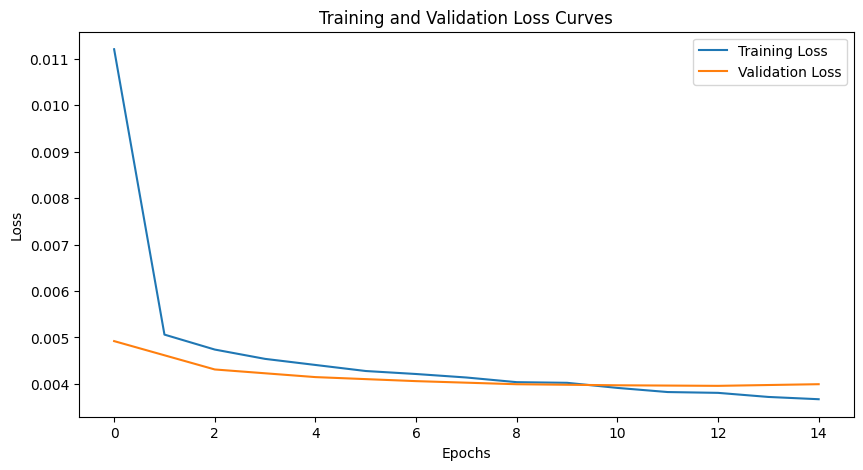

In [10]:
# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(range(0, num_epochs, 2), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


# Val & thresholding

In [11]:
model = MultimodalEnsemble(num_classes).to(device)
model.load_state_dict(torch.load("models/baseline/main/best.pth",map_location=device))
model.eval();

In [12]:
with torch.no_grad():
    all_predictions = []
    all_surveyID = []
    for batch_idx, (data0, data1, data2, data3, targets, surveyID) in enumerate(tqdm(val_loader)):
        data0 = data0.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)
        data3 = data3.to(device)
        targets = targets.to(device)

        outputs = model(data0, data1, data2, data3)
        predictions = torch.sigmoid(outputs).cpu().numpy()

        all_predictions.extend(predictions)
        all_surveyID.extend(surveyID.numpy())
        
all_predictions = np.array(all_predictions)
all_surveyID = np.array(all_surveyID)

100%|██████████| 105/105 [00:29<00:00,  3.51it/s]


In [13]:
train_pa = pd.read_csv(train_metadata_path)
gt = []

for surveyId in tqdm(all_surveyID):
    gt.append(train_pa[train_pa["surveyId"]==surveyId].speciesId.values.astype(int).tolist())
    

len(gt)

100%|██████████| 13349/13349 [00:20<00:00, 659.26it/s]


13349

In [14]:
def eval_pred(pred,gt):
    list_f1 = []
    for p,g in zip(pred,gt):
        sp = set(p)
        sg = set(g)
        TP = len(list(sp.intersection(sg)))
        FP = len(list(sp-sg))
        FN = len(list(sg-sp))
        f1 = TP/(TP + (FP+FN)/2)
        list_f1.append(f1)
    return np.mean(list_f1)

pred_sorted = np.argsort(-all_predictions, axis=1)
best_top_k = 1
best_score = 0
f1_scores = []
for k in tqdm(range(1,100)):
    top_k = pred_sorted[:, :k].tolist()
    score = eval_pred(top_k,gt)
    f1_scores.append(score)
    if score > best_score :
        best_score = score
        best_top_k = k
        
print(f'best score {best_score:.5f} @ top {best_top_k}')

100%|██████████| 99/99 [00:20<00:00,  4.92it/s]

best score 0.40618 @ top 18


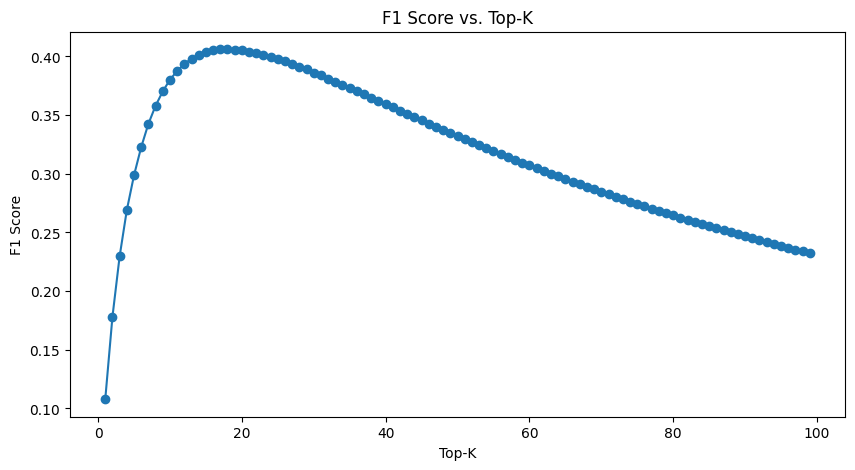

In [15]:
# Plot F1 score vs. top-k
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100), f1_scores, marker='o')
plt.xlabel('Top-K')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Top-K')
plt.show()

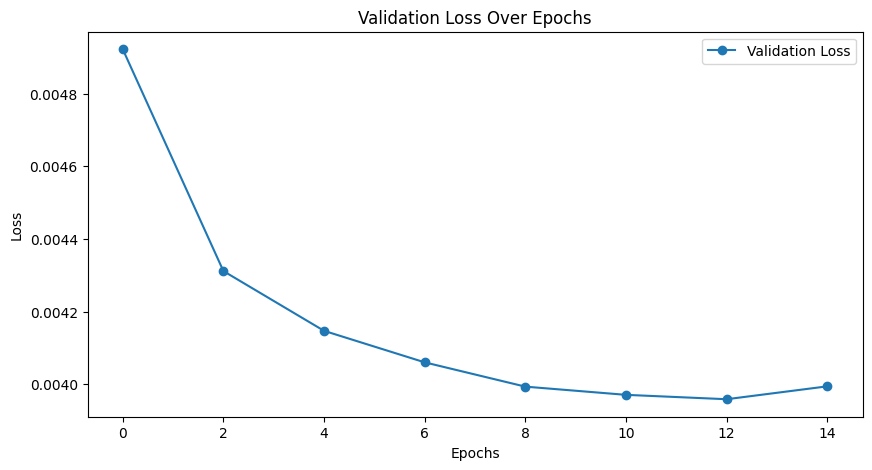

In [16]:
# Assuming val_losses list is already populated during the training process

plt.figure(figsize=(10, 5))
plt.plot(range(0, num_epochs, 2), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()

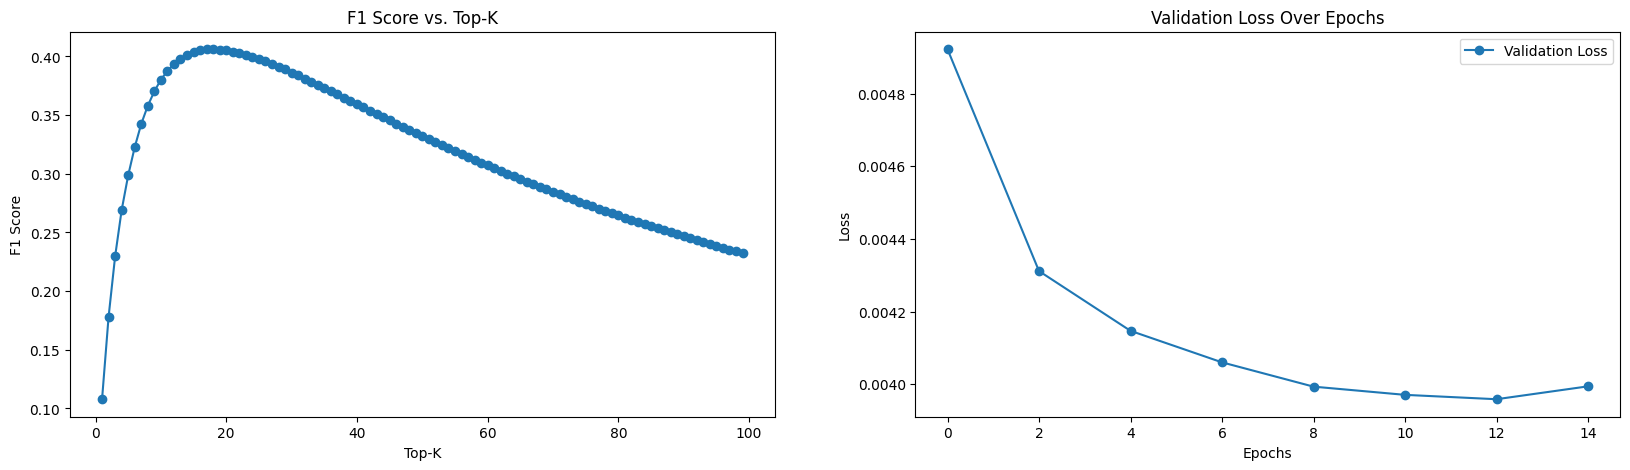

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot F1 score vs. top-k
axs[0].plot(range(1, 100), f1_scores, marker='o')
axs[0].set_xlabel('Top-K')
axs[0].set_ylabel('F1 Score')
axs[0].set_title('F1 Score vs. Top-K')

# Plot validation loss over epochs
axs[1].plot(range(0, num_epochs, 2), val_losses, marker='o', label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Validation Loss Over Epochs')
axs[1].legend()

plt.show()

## Test Loop


In [18]:
model = MultimodalEnsemble(num_classes).to(device)
model.load_state_dict(torch.load("models/baseline/main/best.pth",map_location=device))
model.eval();

In [19]:
with torch.no_grad():
    all_predictions = []
    surveys = []
    top_k_indices = None
    for batch_idx, (data0, data1, data2, data3, surveyID) in enumerate(tqdm(test_loader)):
        data0 = data0.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)
        data3 = data3.to(device)
        targets = targets.to(device)

        outputs = model(data0, data1, data2, data3)
        predictions = torch.sigmoid(outputs).cpu().numpy()

        # Sellect top-k values as predictions
        top_k = np.argsort(-predictions, axis=1)[:, :best_top_k] 
        if top_k_indices is None:
            top_k_indices = top_k
        else:
            top_k_indices = np.concatenate((top_k_indices, top_k), axis=0)

        surveys.extend(surveyID.cpu().numpy())

100%|██████████| 37/37 [00:59<00:00,  1.61s/it]


## Save prediction file!

In [20]:
data_concatenated = [' '.join(map(str, row)) for row in top_k_indices]

pd.DataFrame(
    {'surveyId': surveys,
     'predictions': data_concatenated,
    }).to_csv("research/Baseline_experiments/outputs/baseline-crossval-topk-earlystopping/output.csv", index = False)